In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2, EfficientNetB0
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import time

2025-04-19 13:08:09.833089: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745068090.025835      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745068090.082698      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
IMG_SIZE = 224  # Standard size for many pre-trained models
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.0001

In [5]:
# Define paths
BASE_DIR = '/kaggle/input/breast-cancer-detection'  # Adjust if needed
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALID_DIR = os.path.join(BASE_DIR, 'valid')
TEST_DIR = os.path.join(BASE_DIR, 'test')

In [6]:
print("Dataset Structure:")
for dir_path in [TRAIN_DIR, VALID_DIR, TEST_DIR]:
    benign_count = len(os.listdir(os.path.join(dir_path, '0')))
    malignant_count = len(os.listdir(os.path.join(dir_path, '1')))
    total = benign_count + malignant_count
    print(f"{os.path.basename(dir_path)} set: {total} images ({benign_count} benign, {malignant_count} malignant)")

Dataset Structure:
train set: 2372 images (1569 benign, 803 malignant)
valid set: 675 images (448 benign, 227 malignant)
test set: 336 images (208 benign, 128 malignant)


Train set: 2372 images total
  - Benign (0): 1569 images (66.15%)
  - Malignant (1): 803 images (33.85%)
Validation set: 675 images total
  - Benign (0): 448 images (66.37%)
  - Malignant (1): 227 images (33.63%)
Test set: 336 images total
  - Benign (0): 208 images (61.90%)
  - Malignant (1): 128 images (38.10%)


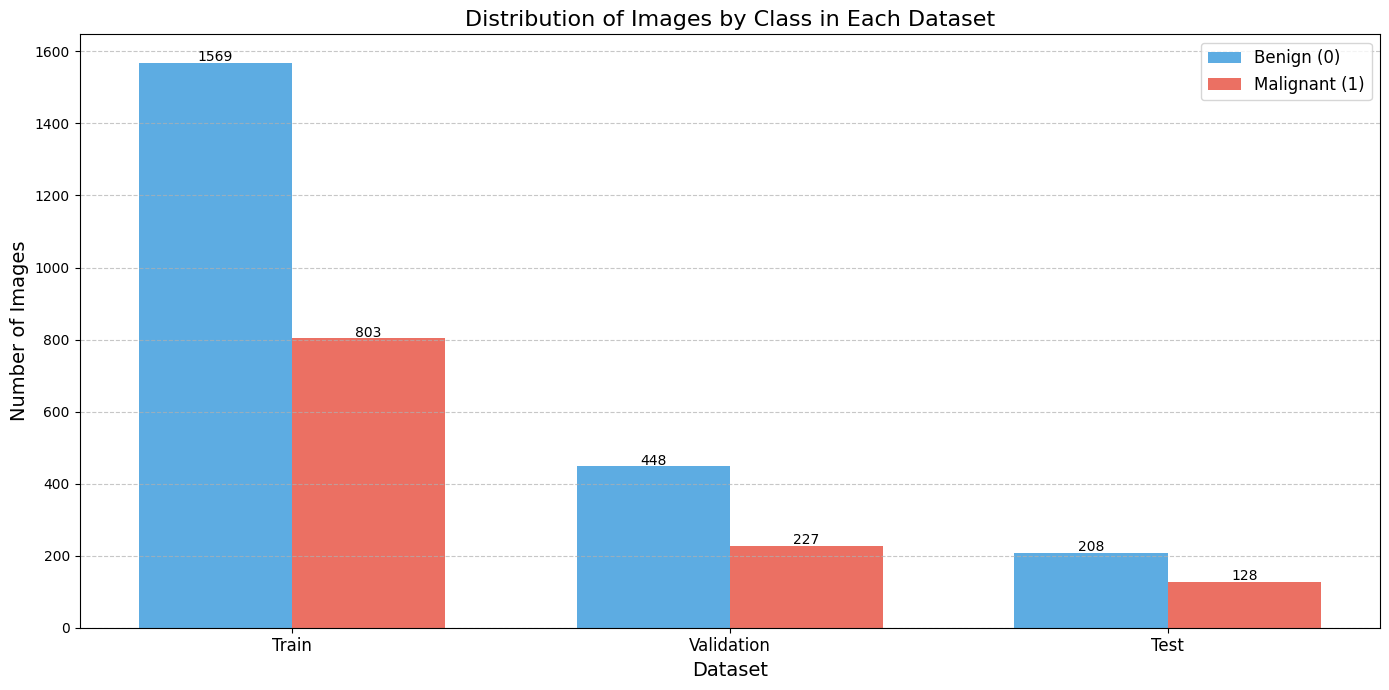


Total dataset: 3383 images
  - Benign (0): 2225 images (65.77%)
  - Malignant (1): 1158 images (34.23%)


In [49]:
datasets = {
    'Train': TRAIN_DIR,
    'Validation': VALID_DIR,
    'Test': TEST_DIR
}

class_counts = {}
for dataset_name, dataset_path in datasets.items():
    benign_count = len(os.listdir(os.path.join(dataset_path, '0')))
    malignant_count = len(os.listdir(os.path.join(dataset_path, '1')))
    class_counts[dataset_name] = {
        'Benign (0)': benign_count,
        'Malignant (1)': malignant_count
    }

plt.figure(figsize=(14, 7))
x = np.arange(len(datasets))
width = 0.35
opacity = 0.8

benign_counts = [class_counts[dataset]['Benign (0)'] for dataset in datasets]
malignant_counts = [class_counts[dataset]['Malignant (1)'] for dataset in datasets]

plt.bar(x - width/2, benign_counts, width, alpha=opacity, color='#3498db', label='Benign (0)')
plt.bar(x + width/2, malignant_counts, width, alpha=opacity, color='#e74c3c', label='Malignant (1)')

plt.xlabel('Dataset', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.title('Distribution of Images by Class in Each Dataset', fontsize=16)
plt.xticks(x, datasets.keys(), fontsize=12)
plt.legend(fontsize=12)

# Add count labels on bars
for i, v in enumerate(benign_counts):
    plt.text(i - width/2, v + 5, str(v), ha='center', fontsize=10)
    
for i, v in enumerate(malignant_counts):
    plt.text(i + width/2, v + 5, str(v), ha='center', fontsize=10)

# Calculate class balance percentage
for dataset_name in datasets:
    total = class_counts[dataset_name]['Benign (0)'] + class_counts[dataset_name]['Malignant (1)']
    benign_pct = class_counts[dataset_name]['Benign (0)'] / total * 100
    malignant_pct = class_counts[dataset_name]['Malignant (1)'] / total * 100
    print(f"{dataset_name} set: {total} images total")
    print(f"  - Benign (0): {class_counts[dataset_name]['Benign (0)']} images ({benign_pct:.2f}%)")
    print(f"  - Malignant (1): {class_counts[dataset_name]['Malignant (1)']} images ({malignant_pct:.2f}%)")

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Calculate total dataset statistics
total_benign = sum(class_counts[dataset]['Benign (0)'] for dataset in datasets)
total_malignant = sum(class_counts[dataset]['Malignant (1)'] for dataset in datasets)
total_images = total_benign + total_malignant

print(f"\nTotal dataset: {total_images} images")
print(f"  - Benign (0): {total_benign} images ({total_benign/total_images*100:.2f}%)")
print(f"  - Malignant (1): {total_malignant} images ({total_malignant/total_images*100:.2f}%)")


Benign Breast Tissue Samples (Class 0):


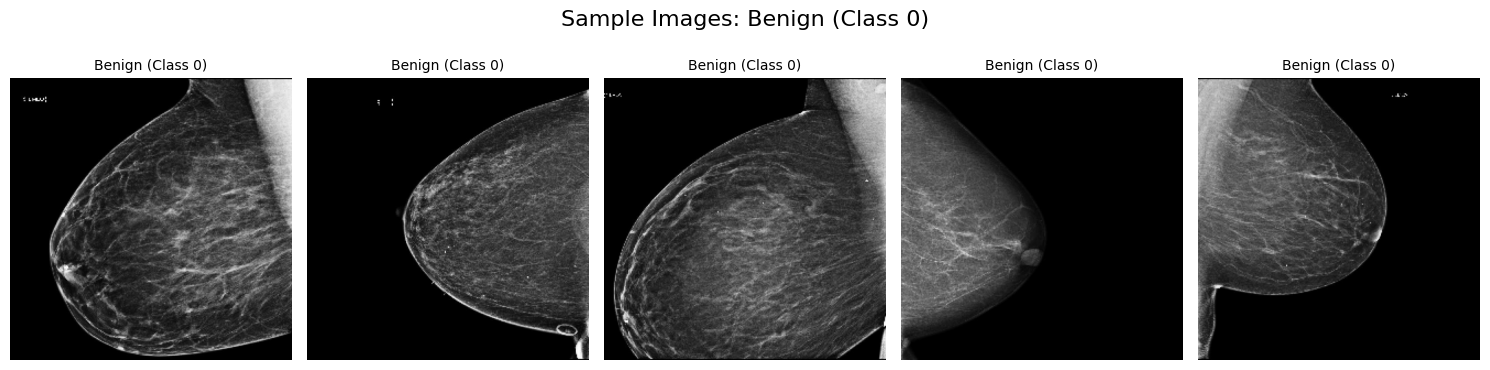


Malignant Breast Tissue Samples (Class 1):


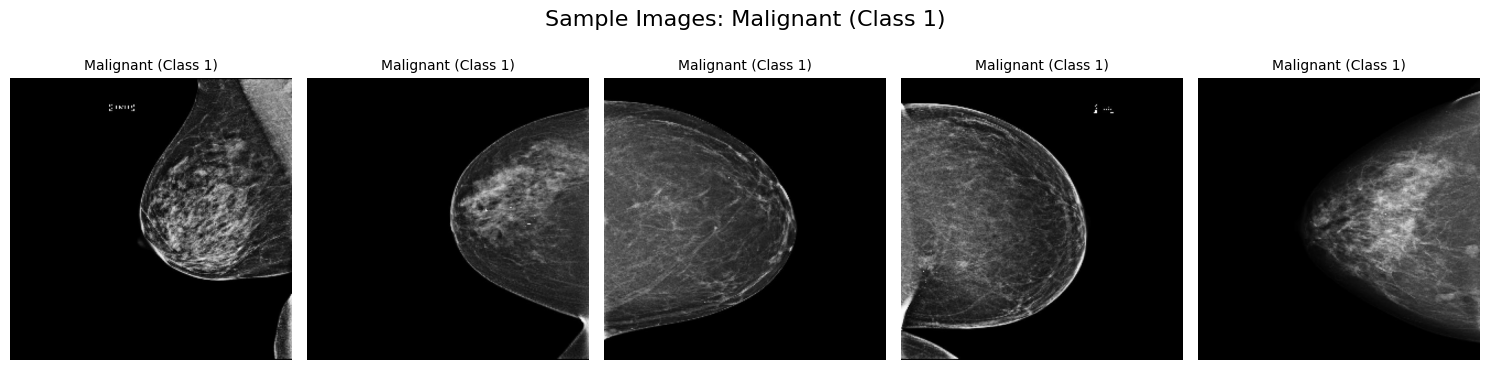


Benign Samples with Histograms:


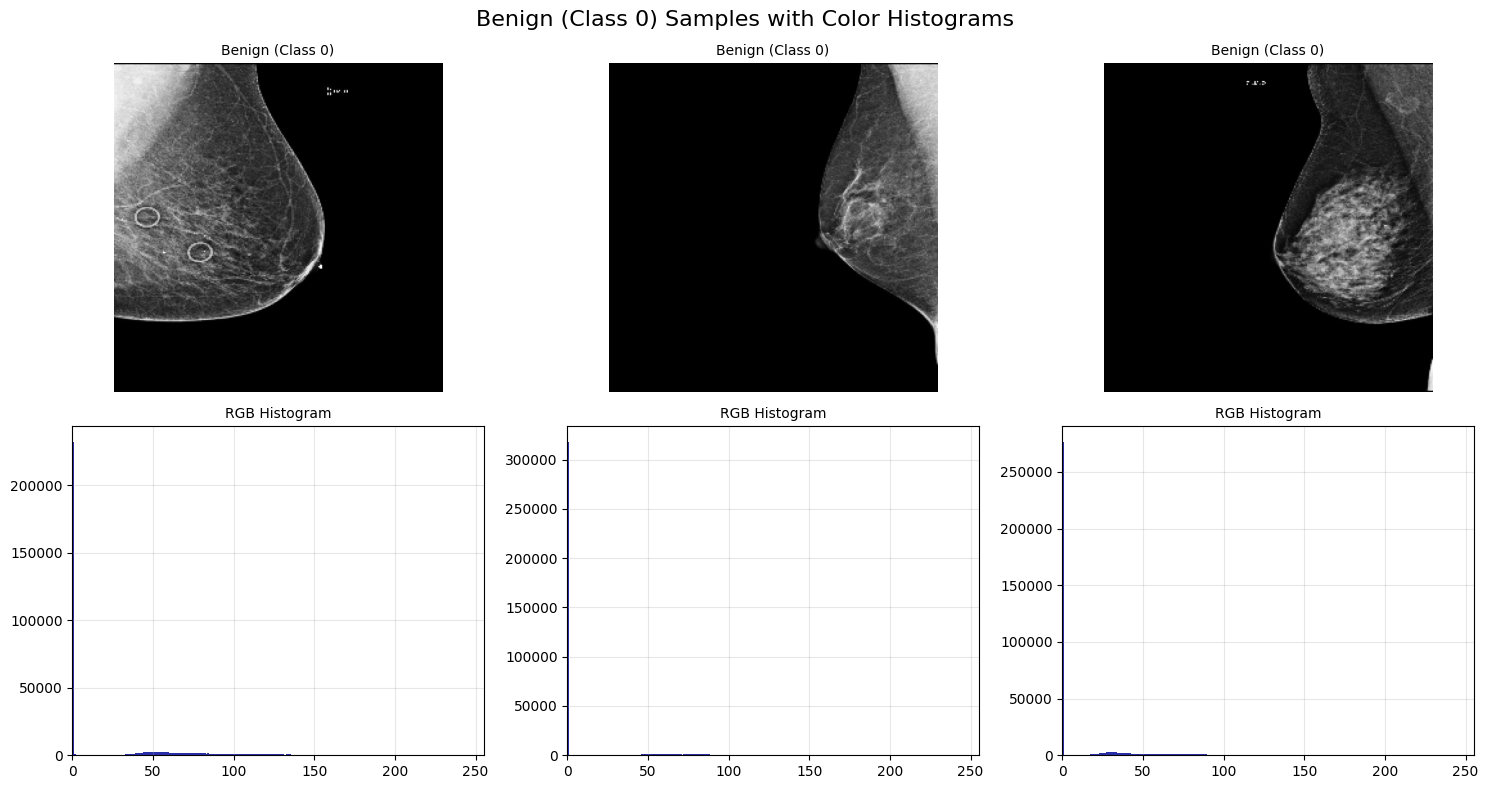


Malignant Samples with Histograms:


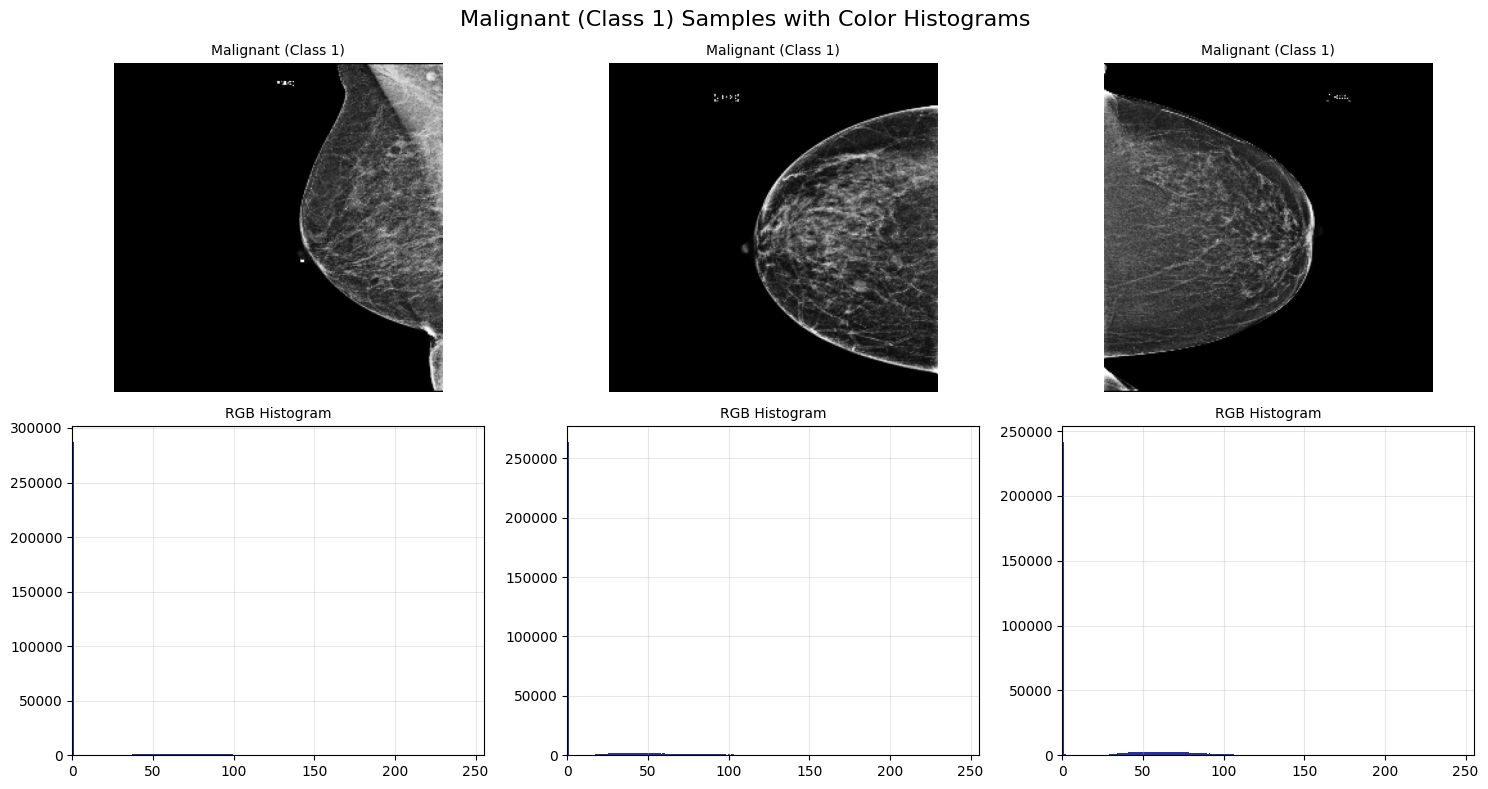


Analyzing image sizes:
Benign image sizes (width × height):
  - 640 × 640: 50 images

Malignant image sizes (width × height):
  - 640 × 640: 50 images


In [57]:
import random
from PIL import Image
def display_sample_images(class_dir, class_name, num_samples=5):
    images = os.listdir(class_dir)
    
    # Randomly select sample images
    if len(images) > num_samples:
        sample_images = random.sample(images, num_samples)
    else:
        sample_images = images
    
    fig, axes = plt.subplots(1, len(sample_images), figsize=(15, 4))
    
    for i, img_name in enumerate(sample_images):
        img_path = os.path.join(class_dir, img_name)
        img = Image.open(img_path)
        
        # Convert to numpy array if not already
        img_array = np.array(img)
        
        # Handle grayscale images (convert to RGB if needed)
        if len(img_array.shape) == 2:
            img_array = np.stack([img_array, img_array, img_array], axis=2)
        
        axes[i].imshow(img_array)
        axes[i].set_title(f"{class_name}", fontsize=10)
        axes[i].axis('off')
    
    plt.suptitle(f"Sample Images: {class_name}", fontsize=16)
    plt.tight_layout()
    plt.show()

# Display sample images from both classes
print("Benign Breast Tissue Samples (Class 0):")
display_sample_images(os.path.join(TRAIN_DIR, '0'), 'Benign (Class 0)')

print("\nMalignant Breast Tissue Samples (Class 1):")
display_sample_images(os.path.join(TRAIN_DIR, '1'), 'Malignant (Class 1)')

# Display the same images with histograms to show color distribution
def display_samples_with_histograms(class_dir, class_name, num_samples=3):
    images = os.listdir(class_dir)
    
    # Randomly select sample images
    if len(images) > num_samples:
        sample_images = random.sample(images, num_samples)
    else:
        sample_images = images
    
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 8))
    
    for i, img_name in enumerate(sample_images):
        img_path = os.path.join(class_dir, img_name)
        img = Image.open(img_path)
        
        # Convert to numpy array if not already
        img_array = np.array(img)
        
        # Handle grayscale images (convert to RGB if needed)
        if len(img_array.shape) == 2:
            img_array = np.stack([img_array, img_array, img_array], axis=2)
        
        # Display image
        axes[0, i].imshow(img_array)
        axes[0, i].set_title(f"{class_name}", fontsize=10)
        axes[0, i].axis('off')
        
        # Display RGB histograms
        for j, color in enumerate(['r', 'g', 'b']):
            if len(img_array.shape) == 3 and img_array.shape[2] >= 3:
                axes[1, i].hist(img_array[:,:,j].ravel(), bins=256, color=color, alpha=0.6)
        
        axes[1, i].set_title('RGB Histogram', fontsize=10)
        axes[1, i].set_xlim([0, 255])
        axes[1, i].grid(alpha=0.3)
    
    plt.suptitle(f"{class_name} Samples with Color Histograms", fontsize=16)
    plt.tight_layout()
    plt.show()

print("\nBenign Samples with Histograms:")
display_samples_with_histograms(os.path.join(TRAIN_DIR, '0'), 'Benign (Class 0)')

print("\nMalignant Samples with Histograms:")
display_samples_with_histograms(os.path.join(TRAIN_DIR, '1'), 'Malignant (Class 1)')

# Display image size information
def analyze_image_sizes(class_dir):
    images = os.listdir(class_dir)
    sizes = []
    
    # Sample up to 50 images to check sizes
    sample_size = min(50, len(images))
    sample_images = random.sample(images, sample_size)
    
    for img_name in sample_images:
        img_path = os.path.join(class_dir, img_name)
        img = Image.open(img_path)
        sizes.append(img.size)  # (width, height)
    
    # Count unique sizes
    unique_sizes = {}
    for size in sizes:
        if size in unique_sizes:
            unique_sizes[size] += 1
        else:
            unique_sizes[size] = 1
    
    return unique_sizes

print("\nAnalyzing image sizes:")
benign_sizes = analyze_image_sizes(os.path.join(TRAIN_DIR, '0'))
malignant_sizes = analyze_image_sizes(os.path.join(TRAIN_DIR, '1'))

print("Benign image sizes (width × height):")
for size, count in benign_sizes.items():
    print(f"  - {size[0]} × {size[1]}: {count} images")

print("\nMalignant image sizes (width × height):")
for size, count in malignant_sizes.items():
    print(f"  - {size[0]} × {size[1]}: {count} images")

In [8]:
def create_data_generators():
    train_datagen = ImageDataGenerator(
        rescale=1./255,)
    valid_test_datagen = ImageDataGenerator(rescale=1./255)
     # Create generators
    train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=True
    )
    
    valid_generator = valid_test_datagen.flow_from_directory(
        VALID_DIR,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False
    )
    
    test_generator = valid_test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False
    )
    
    return train_generator, valid_generator, test_generator

In [9]:
train_generator, valid_generator, test_generator = create_data_generators()

Found 2372 images belonging to 2 classes.
Found 675 images belonging to 2 classes.
Found 336 images belonging to 2 classes.


In [29]:
def get_callbacks(model_name):
    checkpoint = ModelCheckpoint(
        f'{model_name}_best.keras',  # Changed from .h5 to .keras
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
    
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )

In [11]:
def evaluate_model(model, history, test_generator, model_name):
    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f"{model_name} - Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")
    # Make predictions
    y_pred_prob = model.predict(test_generator)
    y_pred = (y_pred_prob > 0.5).astype(int)
    y_true = test_generator.classes
    
    # Classification report
    print(f"\n{model_name} - Classification Report:")
    print(classification_report(y_true, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Benign', 'Malignant'], 
                yticklabels=['Benign', 'Malignant'])
    plt.title(f'{model_name} - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'{model_name} - ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()
    
    # Training history plots
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return test_accuracy, roc_auc

In [20]:
def create_custom_cnn():
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))  # Added proper Input layer
    
    # First convolutional block
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)
    
    # Second convolutional block
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)
    
    # Third convolutional block
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)
    
    # Fourth convolutional block
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)
    
    # Fully connected layers
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [21]:
def create_vgg16_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    # Freeze the base model
    base_model.trainable = False
    
    # Add custom layers
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base_model(inputs, training=False)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model


In [22]:
def create_resnet50_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    # Freeze the base model
    base_model.trainable = False
    
    # Add custom layers
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base_model(inputs, training=False)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [23]:
def create_efficientnet_model():
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    # Freeze the base model
    base_model.trainable = False
    
    # Add custom layers
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base_model(inputs, training=False)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model


In [24]:
results = {}

In [25]:
models_to_train = {
    'Custom CNN': create_custom_cnn,
    'VGG16': create_vgg16_model,
    'ResNet50': create_resnet50_model,
    'EfficientNetB0': create_efficientnet_model
}



--- Training Custom CNN ---
Custom CNN architecture:


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_40               │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 224, 224, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_41               │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_42               │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_43               │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_44               │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 56, 56, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_45               │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 27,001,377 (103.00 MB)

 Trainable params: 26,997,921 (102.99 MB)

 Non-trainable params: 3,456 (13.50 KB)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745068869.376806     122 service.cc:148] XLA service 0x7f5454001dd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745068869.377770     122 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745068870.339275     122 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/75 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.5078 - loss: 0.8903  

I0000 00:00:1745068884.380299     122 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


75/75 ━━━━━━━━━━━━━━━━━━━━ 56s 417ms/step - accuracy: 0.5352 - loss: 0.9941 - val_accuracy: 0.4015 - val_loss: 0.6965
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/20


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step - accuracy: 0.5477 - loss: 0.9108 - val_accuracy: 0.6637 - val_loss: 0.6416
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - accuracy: 0.5549 - loss: 0.8934 - val_accuracy: 0.5956 - val_loss: 0.6761
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - accuracy: 0.5735 - loss: 0.8387 - val_accuracy: 0.4474 - val_loss: 0.7625
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - accuracy: 0.5903 - loss: 0.8093 - val_accuracy: 0.4889 - val_loss: 0.7423
Epoch 10/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - accuracy: 0.5921 - loss: 0.8125 - val_accuracy: 0.5052 - val_lo

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


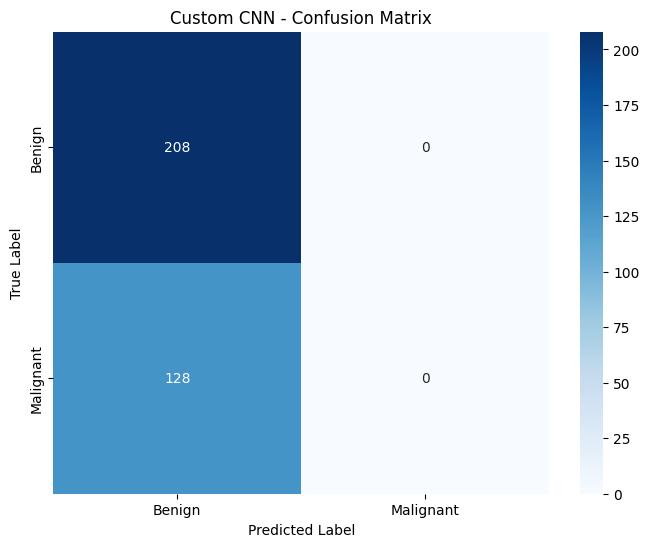

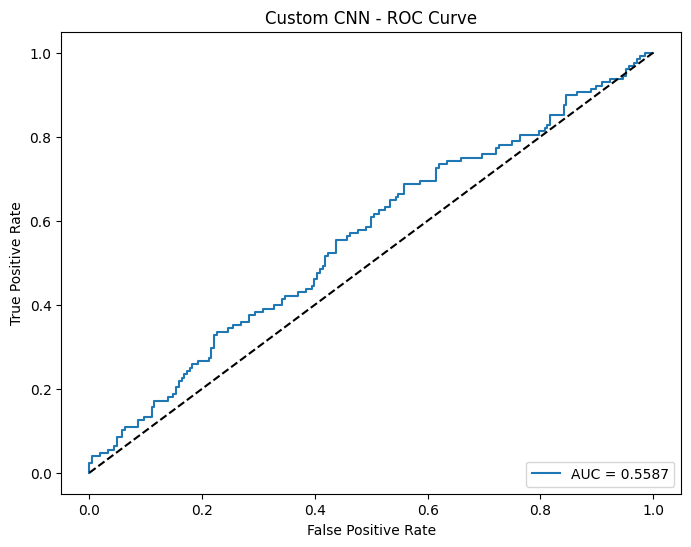

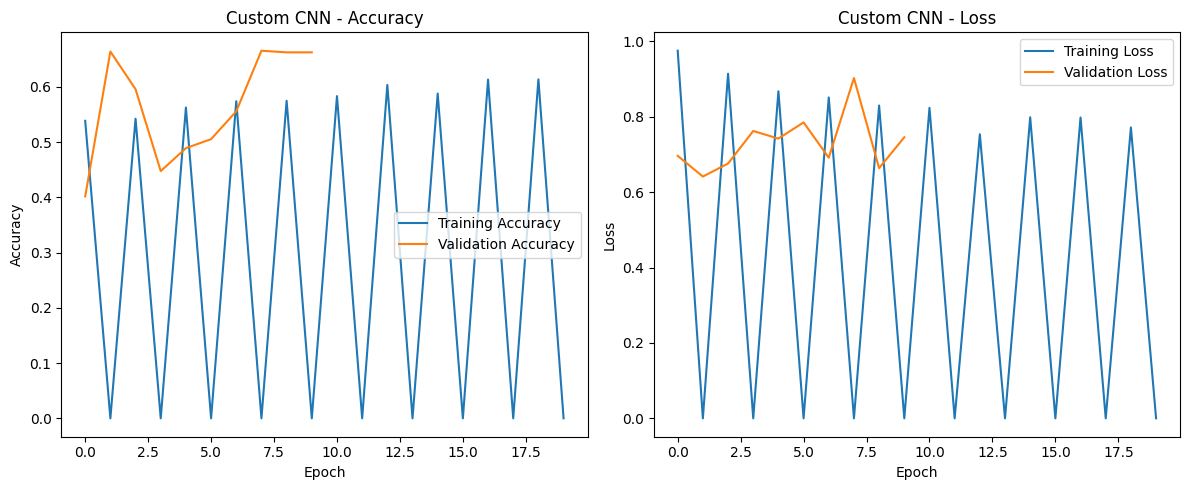


--- Training VGG16 ---
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
VGG16 architecture:


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_50               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_51               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,694,913 (105.65 MB)

 Trainable params: 12,978,689 (49.51 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 28s 200ms/step - accuracy: 0.5280 - loss: 0.9815 - val_accuracy: 0.5926 - val_loss: 0.6685
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/20


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 0.5789 - loss: 0.8446 - val_accuracy: 0.6474 - val_loss: 0.6218
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 158us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - accuracy: 0.6165 - loss: 0.7720 - val_accuracy: 0.6563 - val_loss: 0.6226
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 158us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 0.6396 - loss: 0.7341 - val_accuracy: 0.5748 - val_loss: 0.7214
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 237us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - accuracy: 0.6513 - loss: 0.7280 - val_accuracy: 0.6326 - val_loss: 0.6977
Epoch 10/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - accuracy: 0.6441 - loss: 0.7546 - val_accuracy: 0.6756 - val_lo

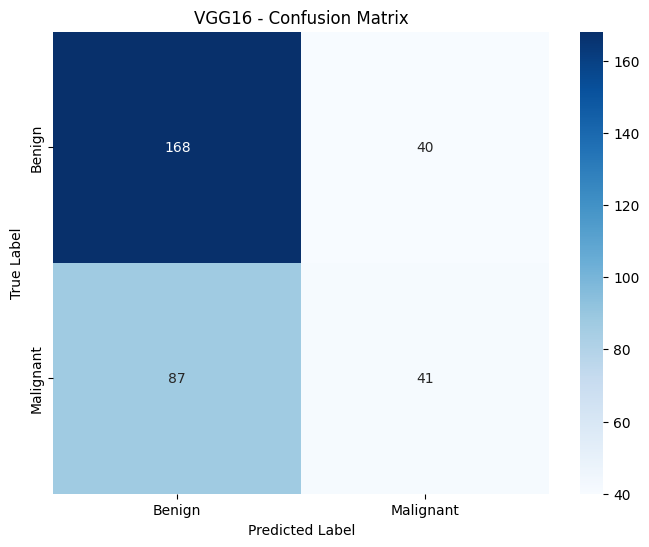

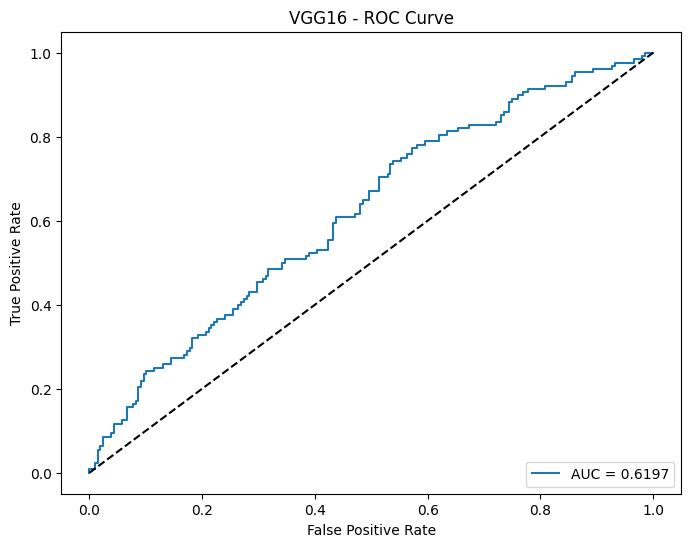

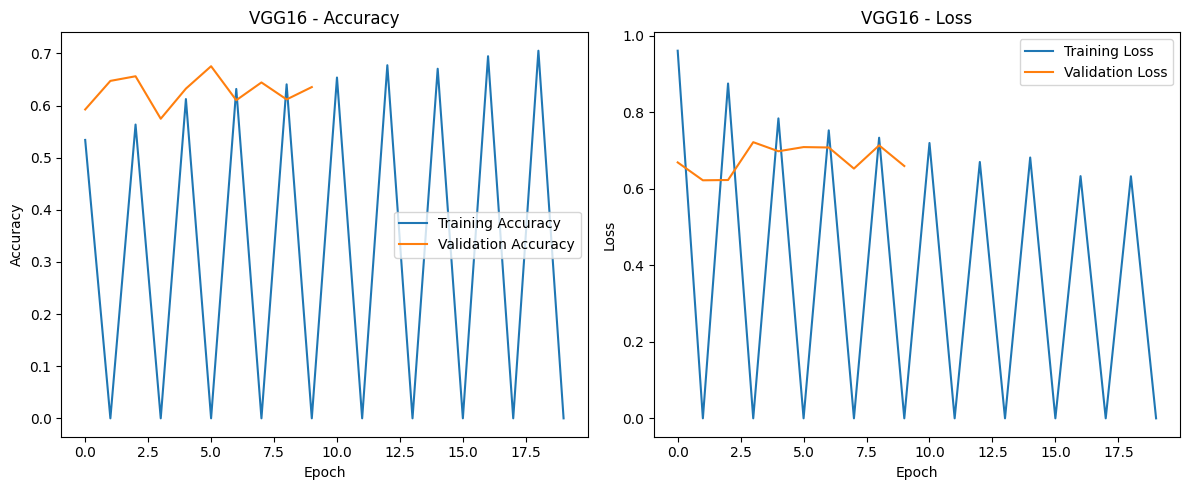


--- Training ResNet50 ---
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
ResNet50 architecture:


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 512)                 │      51,380,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_52               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_53               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 75,103,105 (286.50 MB)

 Trainable params: 51,513,857 (196.51 MB)

 Non-trainable params: 23,589,248 (89.99 MB)

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 37s 262ms/step - accuracy: 0.5199 - loss: 1.0224 - val_accuracy: 0.6637 - val_loss: 1.3534
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/20


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - accuracy: 0.5736 - loss: 0.8252 - val_accuracy: 0.6637 - val_loss: 0.9086
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - accuracy: 0.5841 - loss: 0.8530 - val_accuracy: 0.6637 - val_loss: 0.7197
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - accuracy: 0.6112 - loss: 0.7651 - val_accuracy: 0.6296 - val_loss: 0.6728
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - accuracy: 0.6054 - loss: 0.7817 - val_accuracy: 0.6489 - val_loss: 0.7698
Epoch 10/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy: 0.6437 - loss: 0.7004 - val_accuracy: 0.6607 - val_loss

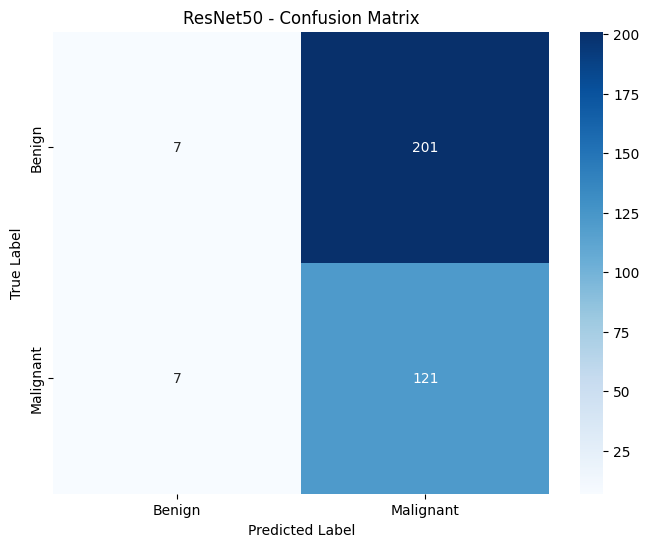

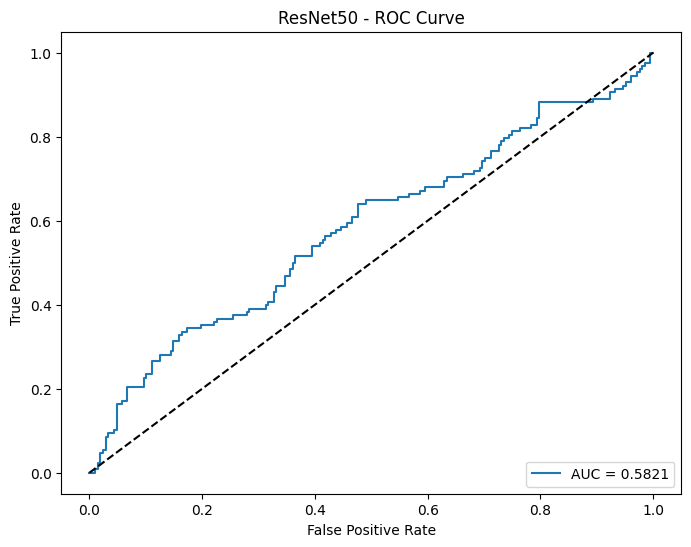

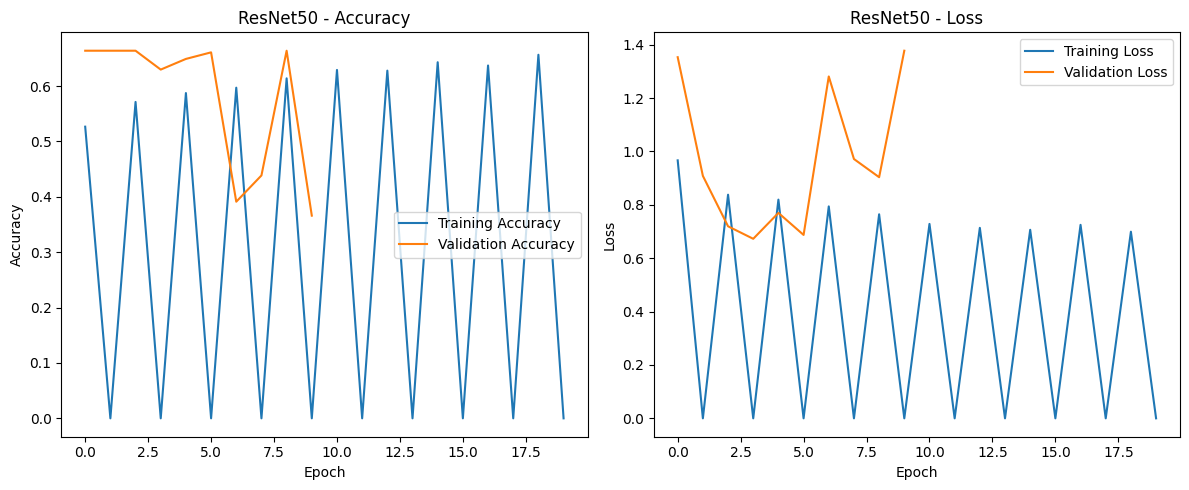


--- Training EfficientNetB0 ---
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
EfficientNetB0 architecture:


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 512)                 │      32,113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_54               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_55               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 36,297,380 (138.46 MB)

 Trainable params: 32,246,273 (123.01 MB)

 Non-trainable params: 4,051,107 (15.45 MB)

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 57s 400ms/step - accuracy: 0.4933 - loss: 0.9983 - val_accuracy: 0.3363 - val_loss: 1.0881
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/20


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy: 0.5067 - loss: 0.9668 - val_accuracy: 0.3363 - val_loss: 4.2349
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - accuracy: 0.5054 - loss: 0.9468 - val_accuracy: 0.3363 - val_loss: 1.8330
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - accuracy: 0.5623 - loss: 0.8606 - val_accuracy: 0.3363 - val_loss: 0.8388
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - accuracy: 0.5518 - loss: 0.8637 - val_accuracy: 0.3363 - val_loss: 0.7694
Epoch 10/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step - accuracy: 0.5461 - loss: 0.8562 - val_accuracy: 0.6637 - val_loss: 

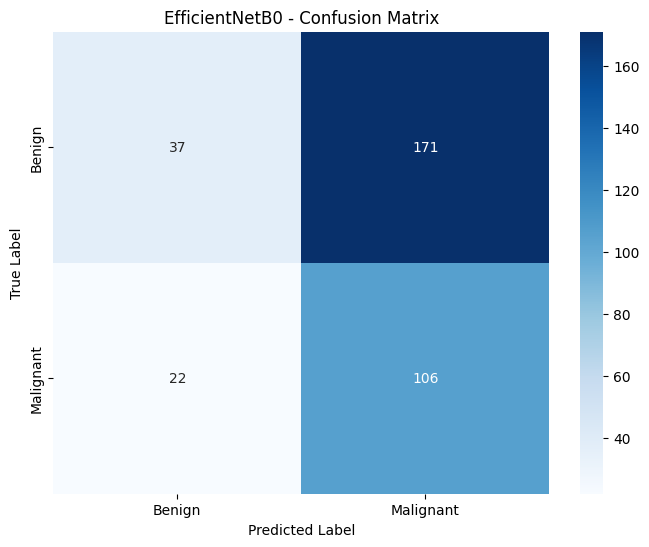

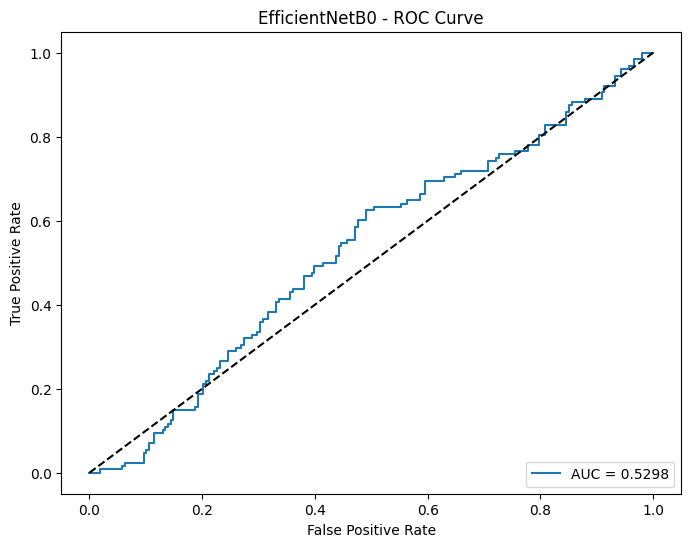

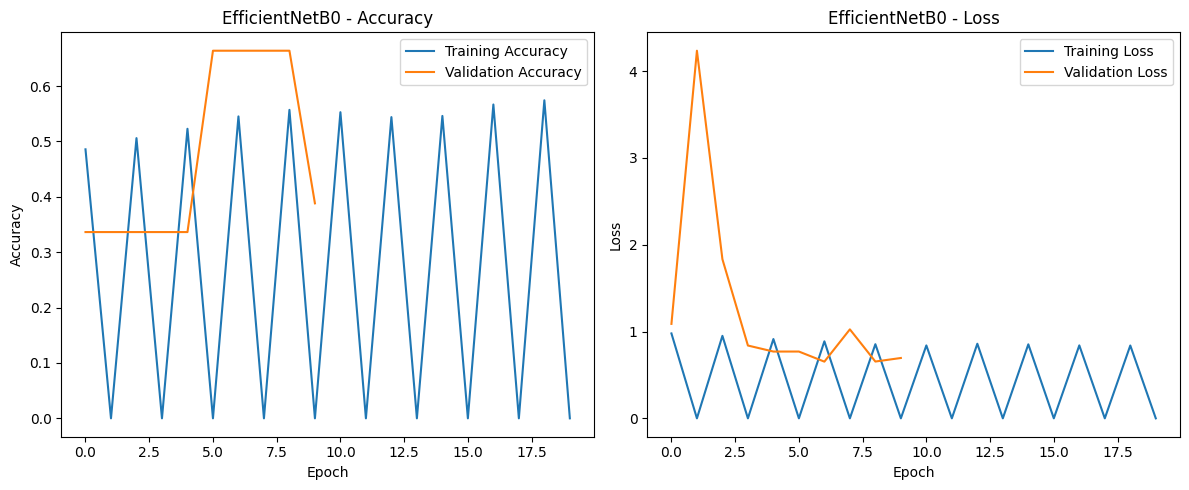

In [30]:
for model_name, model_fn in models_to_train.items():
    print(f"\n--- Training {model_name} ---")
    
    # Create model
    model = model_fn()
    print(f"{model_name} architecture:")
    model.summary()
    
    # Create callbacks
    callbacks = get_callbacks(model_name)
    
    # Calculate steps per epoch
    steps_per_epoch = len(train_generator)
    validation_steps = len(valid_generator)
    
    # Training start time
    start_time = time.time()
    
    # Train model
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=valid_generator,
        callbacks=callbacks,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps
    )
    
    # Training end time
    end_time = time.time()
    training_time = end_time - start_time
    print(f"{model_name} - Training time: {training_time:.2f} seconds")
    
    # Evaluate model
    test_accuracy, roc_auc = evaluate_model(model, history, test_generator, model_name)
    
    # Store results
    results[model_name] = {
        'test_accuracy': test_accuracy,
        'roc_auc': roc_auc,
        'training_time': training_time
    }

In [31]:
print("\n=== Model Comparison ===")
comparison_df = pd.DataFrame(results).T
comparison_df.columns = ['Test Accuracy', 'ROC AUC', 'Training Time (s)']
print(comparison_df)



=== Model Comparison ===
                Test Accuracy   ROC AUC  Training Time (s)
Custom CNN           0.619048  0.558669         144.627990
VGG16                0.622024  0.619704         115.346052
ResNet50             0.380952  0.582106         121.598539
EfficientNetB0       0.425595  0.529785         140.502532


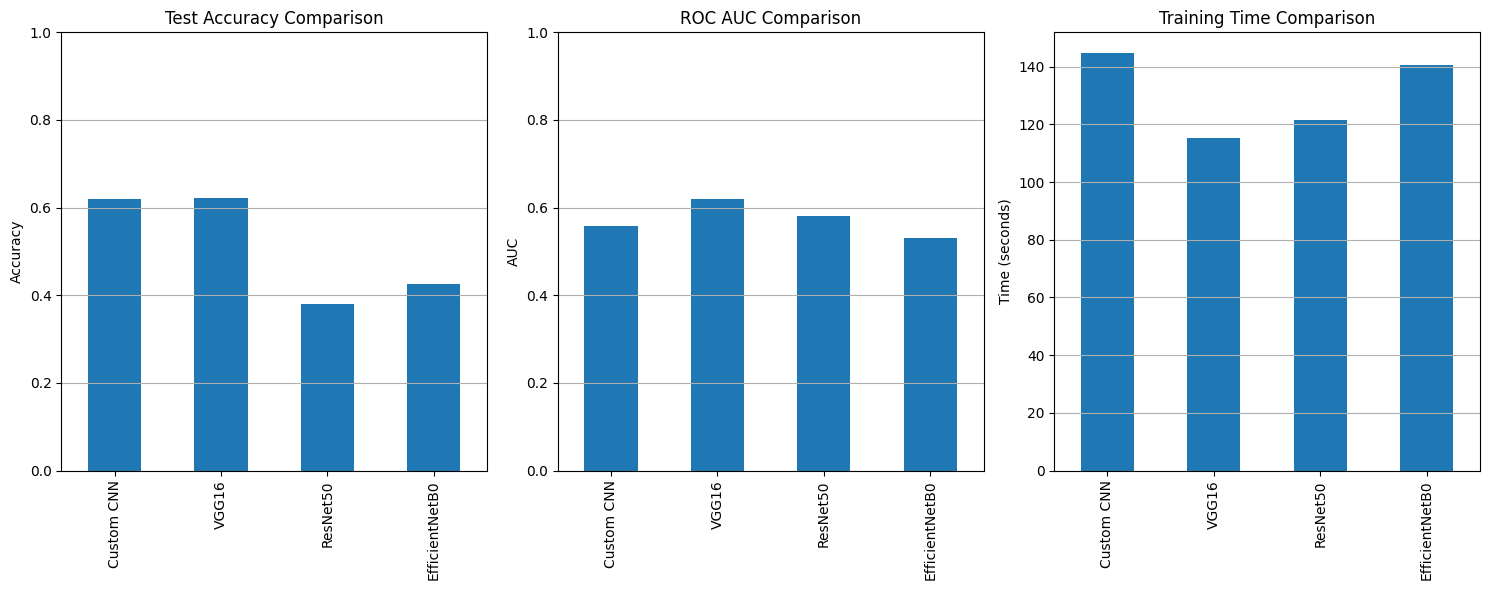

In [32]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
comparison_df['Test Accuracy'].plot(kind='bar')
plt.title('Test Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(axis='y')

plt.subplot(1, 3, 2)
comparison_df['ROC AUC'].plot(kind='bar')
plt.title('ROC AUC Comparison')
plt.ylabel('AUC')
plt.ylim(0, 1)
plt.grid(axis='y')

plt.subplot(1, 3, 3)
comparison_df['Training Time (s)'].plot(kind='bar')
plt.title('Training Time Comparison')
plt.ylabel('Time (seconds)')
plt.grid(axis='y')

plt.tight_layout()
plt.show()


In [33]:
best_model_name = comparison_df['ROC AUC'].idxmax()
print(f"\nBest performing model: {best_model_name}")


Best performing model: VGG16


In [35]:
best_model = create_vgg16_model()
for layer in best_model.layers[1].layers[-4:]:
    layer.trainable = True

In [36]:
best_model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE/10),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [42]:
print(f"\n--- Fine-tuning {best_model_name} ---")
fine_tune_history = best_model.fit(
    train_generator,
    epochs=50,
    validation_data=valid_generator,
    callbacks=get_callbacks(f"{best_model_name}_finetuned"),
    steps_per_epoch=len(train_generator),
    validation_steps=len(valid_generator)
)


--- Fine-tuning VGG16 ---
Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 0.7537 - loss: 0.5266 - val_accuracy: 0.6148 - val_loss: 0.7241
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/50


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - accuracy: 0.7619 - loss: 0.5118 - val_accuracy: 0.6356 - val_loss: 0.7091
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - accuracy: 0.7541 - loss: 0.5164 - val_accuracy: 0.6519 - val_loss: 0.7214
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - accuracy: 0.7714 - loss: 0.4798 - val_accuracy: 0.6607 - val_loss: 0.7000
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 174us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - accuracy: 0.7849 - loss: 0.4687 - val_accuracy: 0.6237 - val_loss: 0.7460
Epoch 10/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 171us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 11/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - accuracy: 0.7776 - loss: 0.4550 - val_accuracy: 0.6756 - val_lo


=== Fine-tuned Model Evaluation ===
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.7040 - loss: 0.7403
VGG16 (Fine-tuned) - Test Accuracy: 0.6488, Test Loss: 0.8445
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step

VGG16 (Fine-tuned) - Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.74      0.72       208
           1       0.54      0.51      0.52       128

    accuracy                           0.65       336
   macro avg       0.62      0.62      0.62       336
weighted avg       0.64      0.65      0.65       336



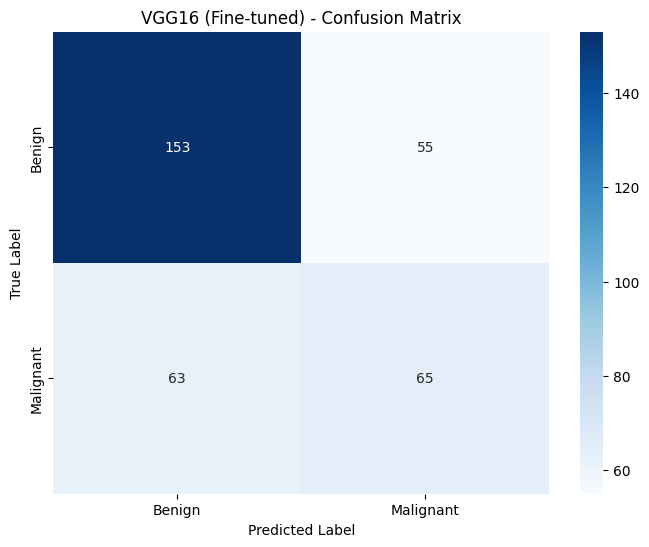

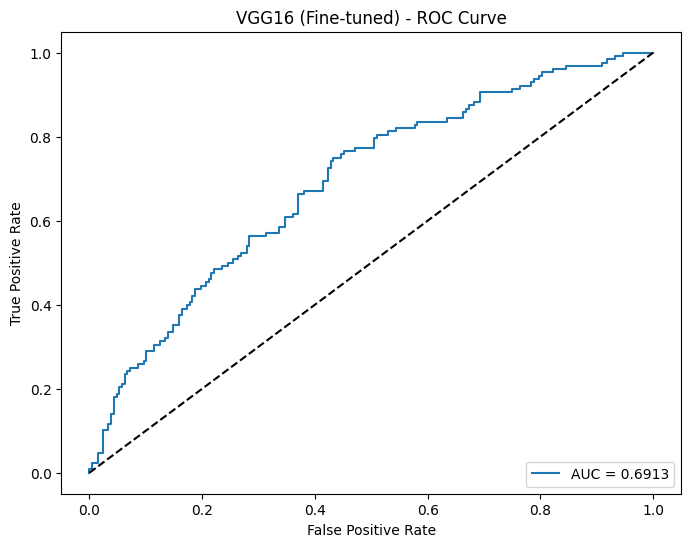

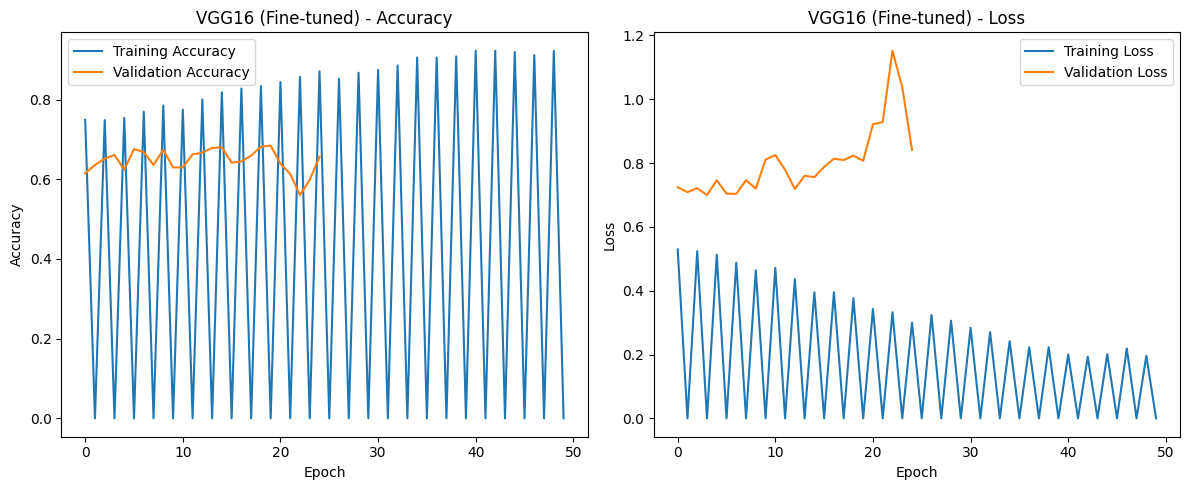

(0.648809552192688, 0.6913311298076924)

In [43]:
print("\n=== Fine-tuned Model Evaluation ===")
evaluate_model(best_model, fine_tune_history, test_generator, f"{best_model_name} (Fine-tuned)")

In [44]:
best_model.save(f"{best_model_name}_final.keras")
print(f"Final model saved as {best_model_name}_final.keras")

Final model saved as VGG16_final.keras
